In [263]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
covid_df = pd.read_csv('owid_covid_data.csv')

pd.options.display.max_rows = 4000

def missing_report_gen(covid_df):
    missing_values = covid_df.isnull().sum()
    missing_percent = (missing_values / len(covid_df)) * 100
    missing_report = pd.DataFrame({'Missing Values': missing_values, 'Percent Missing': missing_percent})
    missing_report = missing_report[missing_report['Missing Values'] > 0]
    
    return missing_report

missing_report = missing_report_gen(covid_df)
missing_report

#### Data Preprocessing
---

In [ ]:
# Removing columns 
high_missing_cols = covid_df.columns[covid_df.isnull().mean() > 0.90]
medium_missing_cols = covid_df.columns[(covid_df.isnull().mean() > 0.50) & (covid_df.isnull().mean() <= 0.90)]

covid_df_clean = covid_df.drop(columns=high_missing_cols).drop(columns=medium_missing_cols)

missing_report_clean = missing_report_gen(covid_df_clean)
missing_report_clean

#### Feature Selection and Derivation


In [266]:
covid_df_clean['case_fatality_rate'] = covid_df_clean['total_deaths'] / covid_df_clean['total_cases']
covid_df_clean['log_total_cases'] = np.log1p(covid_df_clean['total_cases'])
covid_df_clean['log_total_deaths'] = np.log1p(covid_df_clean['total_deaths'])

### Exploratory Data Analysis
---

#### Visualizations

In [ ]:
# Summary statistics for key variables
print(covid_df_clean[['total_cases', 'total_deaths', 'gdp_per_capita', 'life_expectancy']].describe())

# Histograms for total_cases and total_deaths
plt.figure(figsize=(10, 5))
sns.histplot(covid_df_clean['log_total_cases'], kde=True, color='lightgreen')
plt.title('Distribution of Log Total Cases')
plt.xlabel('Log of Total Cases')
plt.ylabel('Number of Countries')
plt.tight_layout
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(covid_df_clean['log_total_deaths'], kde=True, color='lightcoral')
plt.title('Distribution of Log Total Deaths')
plt.xlabel('Log of Total Deaths')
plt.ylabel('Number of Countries')
plt.tight_layout
plt.show()

# Scatterplots
sns.scatterplot(x='gdp_per_capita', y='log_total_cases', data=covid_df_clean)
plt.title('GDP per Capita vs Total COVID-19 Cases (Log Scale)')
plt.show()

sns.scatterplot(x='human_development_index', y='case_fatality_rate', data=covid_df_clean)
plt.title('HDI vs Case Fatality Rate')
plt.show()


# Boxplot for total_cases by continent
sns.boxplot(x='continent', y='log_total_cases', data=covid_df_clean)
plt.xticks(rotation=45)
plt.title('Log Total Cases by Continent')
plt.show()


#### Correlation Analysis

In [ ]:
corr_vars = [
    'total_cases', 'total_deaths', 'case_fatality_rate',
    'gdp_per_capita', 'life_expectancy', 'population_density',
    'human_development_index', 'median_age', 'aged_65_older'
]

sns.heatmap(covid_df_clean[corr_vars].corr(method='pearson'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between COVID-19 Metrics and Socioeconomic Indicators')
plt.show()

In [ ]:
corr_vars = [
    'total_cases', 'total_deaths', 'case_fatality_rate',
    'gdp_per_capita', 'life_expectancy', 'population_density',
    'human_development_index', 'median_age', 'aged_65_older'
]

sns.heatmap(covid_df_clean[corr_vars].corr(method='pearson'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between COVID-19 Metrics and Socioeconomic Indicators')
plt.show()

\newpage

# Uncovering Response Patterns: Clustering Analysis of Global COVID-19 Data

## Clustering Methodology: K-means and Hierarchical Approaches

This section leverages two complementary clustering techniques: K-means and agglomerative hierarchical clustering to uncover groups of countries whose COVID-19 trajectories and outcomes share similar patterns. After normalizing key pandemic indicators alongside socioeconomic variables, K-means partitions nations into compact clusters; and hierarchical clustering builds a nested tree of country groupings without prespecifying the number of clusters. Together, these methods provide a robust foundation for revealing how underlying social and economic factors shaped the global progression of the pandemic.

**K-means**

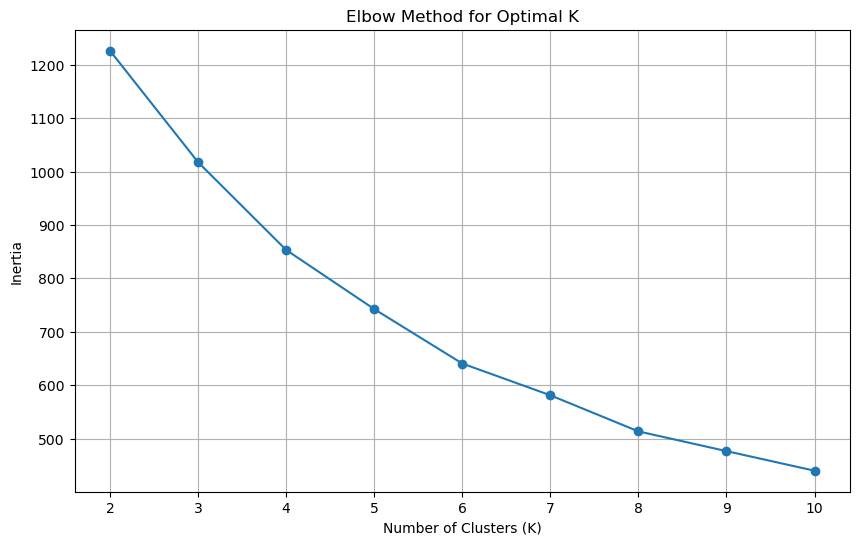

In [270]:
# -=-=-= Data for clustering -=-=-=-
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting relevant features for clustering
clustering_features = [
     'total_cases_per_million',
     'total_deaths_per_million',
     'case_fatality_rate',
     'gdp_per_capita',
     'hospital_beds_per_thousand',
     'median_age',
     'population_density',
     'human_development_index'
 ]

latest = (
    covid_df
    .dropna(subset=['iso_code'])
    .sort_values('date')
    .groupby('iso_code', as_index=False)
    .tail(1)
)
latest = latest[latest['total_cases'] > 0].copy()
latest['case_fatality_rate'] = latest['total_deaths'] / latest['total_cases']

covid_clustering_data = latest[clustering_features].replace([np.inf, -np.inf], np.nan)
covid_clustering_data.replace([np.inf, -np.inf], np.nan, inplace=True)
means = covid_clustering_data.mean()
covid_clustering_data.fillna(means, inplace=True)

# Standardizing the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(covid_clustering_data)
scaled_df = pd.DataFrame(scaled_features, columns=covid_clustering_data.columns)

# pptimal number of clusters using the Elbow method
inertia = []
k_range = range(2, 11)  
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) #  n_init for stability
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Based on the elbow plot -SEED 42- (could be 3 also)
optimal_k = 4


Observing the elbow plot, a distinct bend occurs around $K=3$ or $K=4$. Prior to this point, there is a steep decline in inertia, suggesting that increasing the number of clusters significantly reduces inter-cluster variance. However, beyond $K=4$, the decrease in inertia becomes less pronounced, indicating that adding more clusters provides diminishing returns in terms of reducing the overall dispersion within the clusters. Therefore, based on the Elbow method, the optimal number of clusters for this K-means analysis is likely 4.

\newpage

In [271]:
# -=-=-= Use k-means to partition nations into compact clusters -=-=-=-

#  K-means 
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
covid_clustering_data['kmeans_cluster'] = kmeans_final.fit_predict(scaled_df)

# Analyze the cluster
cluster_analysis = covid_clustering_data.groupby('kmeans_cluster')[clustering_features].mean()

print("\nK-means Cluster Analysis")

for cluster_num, characteristics in cluster_analysis.iterrows():
    print(f"Cluster {cluster_num}:")
    for feature, mean_value in characteristics.items():
        print(f"- {feature}: {mean_value:.2f}") 
    print("\n---") 


K-means Cluster Analysis
Cluster 0:
- total_cases_per_million: 12823.23
- total_deaths_per_million: 195.96
- case_fatality_rate: 0.02
- gdp_per_capita: 4198.00
- hospital_beds_per_thousand: 1.63
- median_age: 20.62
- population_density: 132.94
- human_development_index: 0.55

---
Cluster 1:
- total_cases_per_million: 205142.18
- total_deaths_per_million: 1099.18
- case_fatality_rate: 0.01
- gdp_per_capita: 16884.35
- hospital_beds_per_thousand: 2.84
- median_age: 30.40
- population_density: 215.00
- human_development_index: 0.74

---
Cluster 2:
- total_cases_per_million: 392245.99
- total_deaths_per_million: 2628.22
- case_fatality_rate: 0.01
- gdp_per_capita: 35570.52
- hospital_beds_per_thousand: 4.50
- median_age: 39.54
- population_density: 418.67
- human_development_index: 0.86

---
Cluster 3:
- total_cases_per_million: 441115.30
- total_deaths_per_million: 1720.20
- case_fatality_rate: 0.00
- gdp_per_capita: 18211.36
- hospital_beds_per_thousand: 13.80
- median_age: 30.02
- popu

\newpage

**K-means Interpretation**

- Cluster 0 is characterized by very low case and death burdens alongside low income and young populations This cluster likely captures lower resource, youthful nations that saw relatively limited spread or reporting of COVID. 
- Cluster 1 is solidly in the lower-middle to upper-middle development range. This cluster represents nations with moderate socioeconomic development and a correspondingly moderate impact from the pandemic.
- Cluster 2 includes some of the wealthiest, most heavily affected and often most densely populated countries. these are high income or advanced economy nations that experienced widespread, but ultimately well managed outbreaks. 
- Cluster 3 is somewhat unique: extremely high density paired with very high case counts, yet a moderate death toll. Overall, the data suggest small, city-state or specialized jurisdictions places like Singapore or Hong Kong where dense populations, abundant health infrastructure, and aggressive testing drive up case detection while keeping deaths comparatively in check.

**Hierarchical Clustering**

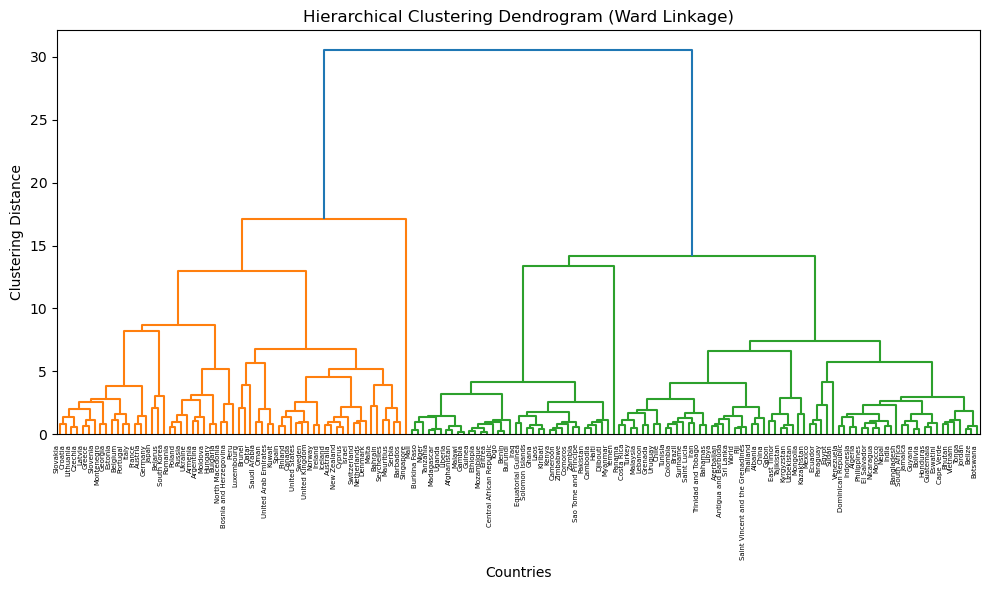

In [272]:
# -=-=-= Hierarchical clustering to build country groupings -=-=-=
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Get latest values for each country for the selected features
latest_covid_data_hc = covid_df_clean.groupby('location')[clustering_features].last().dropna()
latest_covid_data_hc.replace([np.inf, -np.inf], np.nan, inplace=True)
latest_covid_data_hc.fillna(latest_covid_data_hc.mean(), inplace=True)

# Scale data
scaler_hc = StandardScaler()
scaled_features_hc = scaler_hc.fit_transform(latest_covid_data_hc)
scaled_df_hc = pd.DataFrame(scaled_features_hc, index=latest_covid_data_hc.index, columns=latest_covid_data_hc.columns)

# Hierarchical Clustering
hierarchical_clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
clusters_hierarchical = hierarchical_clustering.fit_predict(scaled_df_hc)
latest_covid_data_hc['hierarchical_cluster'] = clusters_hierarchical

cluster_analysis_hierarchical = latest_covid_data_hc.groupby('hierarchical_cluster')[clustering_features].mean()

# Dendrogram
linked = linkage(scaled_df_hc, 'ward')

plt.figure(figsize=(10, 6))
dendrogram(linked,
            orientation='top',
            labels=latest_covid_data_hc.index.tolist(), 
            distance_sort='descending',
            show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('Countries')
plt.ylabel('Clustering Distance')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

n_clusters_choice = 4
hierarchical_clustering_n    = AgglomerativeClustering(n_clusters=n_clusters_choice, linkage='ward')
clusters_n = hierarchical_clustering_n.fit_predict(scaled_df_hc)
latest_covid_data_hc['hierarchical_cluster_n'] = clusters_n


cluster_analysis_n = latest_covid_data_hc.groupby('hierarchical_cluster_n')[clustering_features].mean()
# print(f"\nCharacteristics of Hierarchical Clusters (with {n_clusters_choice} clusters):")
# print("\nMean Feature Values per Cluster:\n")

# for cluster_num, characteristics in cluster_analysis_n.iterrows():
#     print(f"Hierarchical Cluster {cluster_num}:")
#     for feature, mean_value in characteristics.items():
#         print(f"- {feature}: {mean_value:.2f}")
#     print("\n---")


**Dendrogram Interpretation**

The dendrogram shows a clear split: one branch contains low-income, young-population countries with few cases and deaths, while the other includes all remaining nations. That branch then divides into middle-income, moderate-impact countries and wealthy, dense or micro jurisdictions with very high case counts but low fatality rates. Near the leaves, nearly identical neighbors merge at low distances, reflecting almost indistinguishable profiles. At intermediate levels, emerging economies group separately from both low-resource and advanced economies, confirming three natural tiers: low-impact, low-resource nations; middle-income, moderate-outbreak countries; and high-capacity, high-impact jurisdictions.